# NLP Analysis of google reviews

In [217]:
import pandas as pd
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

## Import and clean df

In [222]:
merged_df = pd.read_csv("../raw_data/merged_reviews.csv")
merged_df.head(1)

,Unnamed: 0,restaurant_name,comment_names,comment_ratings,comment_dates,year,comment_comments,type,rating,review_count,...,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
0,0,Augusto Lisboa,Lee Bradshaw,5,2021-11-18 20:25:36.954537,2021,Well worth the small wait to get in of around ...,brunch,4.8,1032.0,...,-9.130176,1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça


In [227]:
cleaned_merged_df = merged_df.drop(columns=['Unnamed: 0', 'review_count', 'rating'])
cleaned_merged_df.head(1)

,restaurant_name,comment_names,comment_ratings,comment_dates,year,comment_comments,type,price,address,label,...,longitude,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
0,Augusto Lisboa,Lee Bradshaw,5,2021-11-18 20:25:36.954537,2021,Well worth the small wait to get in of around ...,brunch,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",...,-9.130176,1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça


In [228]:
cleaned_merged_df.columns

Index(['restaurant_name', 'comment_names', 'comment_ratings', 'comment_dates',
       'year', 'comment_comments', 'type', 'price', 'address', 'label',
       'latitude', 'longitude', 'dine_in', 'takeaway', 'delivery',
       'drive_through', 'no_del_exp', 'curb_pickup', 'postal_code',
       'municipality', 'neighborhood'],
      dtype='object')

### proportion of ratings

In [292]:
def review_proportions(df):
    rating_prop_df = pd.DataFrame\
    ((df.comment_ratings.value_counts()/df.shape[0])*100)\
    .rename(columns = {'comment_ratings':'proportion'}).sort_index(ascending=False) #calculate percentage, rename column and sort index

    rating_prop_df.index.names = ['ratings'] # rename index

    rating_prop_df.proportion = rating_prop_df.proportion.map(lambda x: round(x)) # round % figures
    
    return rating_prop_df

In [293]:
review_proportions(cleaned_merged_df)

,proportion
ratings,
5,68
4,16
3,6
2,4
1,6


### how many reviews originally in portuguese?

In [277]:
cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find(" pelo")).isdigit()==True else 0).sum() #how many reviews translated into portuguese?

7403

In [280]:
cleaned_merged_df['in_portuguese?'] = cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find(" pelo")).isdigit()==True else 0) #create a new column to say which columns are portguese

### proportion of ratings without translated portuguese reviews

In [284]:
english_reviews_df = cleaned_merged_df[cleaned_merged_df['in_portuguese?'] == 0] # reviews only in English

In [336]:
review_proportions(english_reviews_df) #proportion almost the same as the df including translated portuguese reviews

,proportion
ratings,
5,69
4,16
3,6
2,4
1,6


### how many reviews incomplete?

In [333]:
cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find("…More")).isdigit()==True else 0).sum() #how many reviews translated into portuguese?

11884

In [354]:
cleaned_merged_df['unfinised?'] = cleaned_merged_df.comment_comments.map(lambda x: 1 if str(x.find("…More")).isdigit()==True else 0)

In [ ]:
cleaned_merged_df

### proportion of ratings with only reviews complete

In [356]:
complete_reviews_df = cleaned_merged_df[cleaned_merged_df['unfinised?'] == 0]
incomplete_reviews_df = cleaned_merged_df[cleaned_merged_df['unfinised?'] == 1]

In [369]:
incomplete_reviews_df.comment_comments.iloc[11]

'The BEST place to go for brunch in Lisboa.\n\nTucked away in a little street in Alfama it has all the flair of that …More'

In [358]:
review_proportions(complete_reviews_df) #proportion almost the same as the df including translated portuguese reviews

,proportion
ratings,
5,70
4,16
3,6
2,3
1,5


In [340]:
complete_reviews_df.shape

(48021, 23)

## NLP preproc

In [120]:
def clean(text, list_form=False):
    """clean's text for NLP. If list_form set to False returns string otherwise returns list, by default set to False"""
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
        
    lowercased = text.lower() # Lower Case
    
    #unaccented_string = unidecode.unidecode(lowercased) # remove accents
    
    tokenized = word_tokenize(lowercased) # Tokenize
    
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    
    stop_words = set(stopwords.words('english')) # Make stopword list
    
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    
    if list_form == True:
        return without_stopwords
    else:
        return " ".join(without_stopwords)

In [121]:
filtered_df['clean_comment'] = filtered_df['comment_comments'].apply(clean)

In [122]:
filtered_df.shape

(55424, 25)

In [144]:
filtered_df.tail(1).comment_comments

55423    First time I see it selling a 33cl beer as if ...
Name: comment_comments, dtype: object

In [295]:
english_reviews_df['clean_comment'] = english_reviews_df['comment_comments'].apply(clean)

/tmp/ipykernel_1091/4230231936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['clean_comment'] = english_reviews_df['comment_comments'].apply(clean)


## LIME

In [ ]:
filtered_df['good_bad_review'] = filtered_df.comment_ratings.map(lambda x: 1 if x >=4.0 else 0)
reviews_model_df = filtered_df[['clean_comment', 'good_bad_review']]

In [298]:
english_reviews_df['good_bad_review'] = english_reviews_df.comment_ratings.map(lambda x: 1 if x >=4.0 else 0)
en_reviews_model_df = english_reviews_df[['clean_comment', 'good_bad_review']]

/tmp/ipykernel_1091/3444445765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df['good_bad_review'] = english_reviews_df.comment_ratings.map(lambda x: 1 if x >=4.0 else 0)


In [326]:
import sklearn.metrics as metrics
reviews_model_df = reviews_model_df.sample(frac = 1)
X_train, X_test, y_train, y_test = train_test_split(reviews_model_df['clean_comment'], reviews_model_df['good_bad_review'], random_state=42)

# create bag-of-words with weights using tfid vectoriser
# strip accents and remove stop words during vectorisation
tf=TfidfVectorizer(strip_accents = 'ascii', stop_words='english')

# transform and fit the training set with vectoriser
X_train_tf = tf.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tf.transform(X_test)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=42, penalty='l2', solver='newton-cg', C=10)
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test, pred, average='weighted')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


0.9128523180699947

In [327]:
# importing the libraries
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# converting the vectoriser and model into a pipeline
# this is necessary as LIME takes a model pipeline as an input
c = make_pipeline(tf, model)

# saving a list of strings version of the X_test object
ls_X_test= list(X_test)

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'bad review', 1:'good review'}

In [129]:
# create the LIME explainer
# add the class names for interpretability
LIME_explainer = LimeTextExplainer(class_names=class_names)

# choose a random single prediction
idx = 305
# explain the chosen prediction 
# use the probability results of the logistic regression
# can also add num_features parameter to reduce the number of features explained
LIME_exp = LIME_explainer.explain_instance(ls_X_test[idx], c.predict_proba)
# print results
print('Document id: %d' % idx)
print('Review: ', ls_X_test[idx])
print('Probability good review =', c.predict_proba([ls_X_test[idx]]).round(3)[0,1])
print('True class: %s' % class_names.get(list(y_test)[idx]))

Document id: 305
Review:  cool place great service interesting tasting menu loved sea urchin
Probability good review = 0.986
True class: good review


In [130]:
# print class names to show what classes the viz refers to
print("1 = good review, 0 = bad review")
# show the explainability results with highlighted text
LIME_exp.show_in_notebook(text=True)

1 = good review, 0 = bad review


## Tfidf

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(stopwords.words('english')) # Make stopword list

# Tuned TFidfvectorizer
def Tfidf_fit(series):
    vec = TfidfVectorizer(ngram_range = (2,2), min_df=0.1, max_df=0.9).fit(series)
    return vec

def transform_create_list(series):
    vectors = Tfidf_fit(series).transform(series) # Transform text to vectors

    sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

    tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     Tfidf_fit(series).vocabulary_.items()]  # Get the word and associated weight

    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

    return sorted_tfidf_list[:10]

In [132]:
Tfidf_fit(filtered_df.clean_comment)
transform_create_list(filtered_df.clean_comment)

[('traduzido pelo', 5178.142958629467), ('pelo google', 5178.142958629467)]

### Word Cloud & N_Grams

In [133]:
text = " ".join(review for review in filtered_df.comment_comments.astype(str))

In [134]:
token_list = clean(text, list_form=True) 

In [135]:
!pip install wordcloud

In [136]:
 from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

plt.rcParams["figure.figsize"] = [16, 9]

def create_ngrams(token_list, nb_elements):
    """
    Create n-grams for list of tokens. Parameters: token_list : list of strings, nb_elements : number of elements in the n-gram
    Returns: Generator, generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)


def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens. Parameters: ngrams_number : int, number_top_words : int, output dataframe length
    Returns. DataFrame, Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()


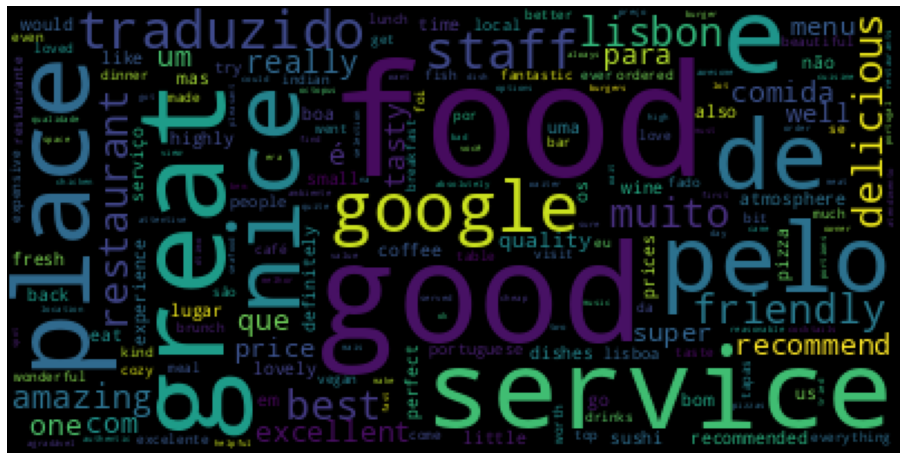

In [137]:
make_word_cloud(token_list, stop_words=stop_words)

In [138]:
frequent_words(token_list, ngrams_number=1, number_top_words=15)

[('food', 19835),
 ('good', 14991),
 ('great', 11506),
 ('service', 10427),
 ('e', 9838),
 ('place', 9590),
 ('pelo', 7550),
 ('nice', 7545),
 ('de', 7513),
 ('google', 7475),
 ('traduzido', 7324),
 ('staff', 6666),
 ('friendly', 5890),
 ('restaurant', 5661),
 ('delicious', 5418)]

In [139]:
frequent_words(token_list, ngrams_number=2, number_top_words=15)

[('traduzido pelo', 7323),
 ('pelo google', 7323),
 ('good food', 1987),
 ('great food', 1656),
 ('food good', 1545),
 ('friendly staff', 1524),
 ('food great', 1244),
 ('good service', 1137),
 ('great service', 1119),
 ('delicious food', 1021),
 ('one best', 969),
 ('highly recommend', 894),
 ('really good', 886),
 ('nice place', 864),
 ('muito bom', 845)]

In [140]:
frequent_words(token_list, ngrams_number=3, number_top_words=15)

[('traduzido pelo google', 7323),
 ('pelo google comida', 418),
 ('pelo google muito', 336),
 ('pelo google lugar', 312),
 ('food great service', 305),
 ('pelo google excelente', 305),
 ('pelo google um', 305),
 ('food good service', 263),
 ('great food great', 253),
 ('good food good', 233),
 ('food friendly staff', 202),
 ('pastel de nata', 190),
 ('service good food', 186),
 ('café da manhã', 183),
 ('pelo google melhor', 180)]